In [ ]:
!pip install geoplot

In [ ]:
pip install jupyter-ai

Note: you may need to restart the kernel to use updated packages.


In [ ]:
###################################################
#-----importing library---------------------------
###################################################
import pandas as pd
import numpy as np
import time
import copy
import random

In [ ]:
# prompt: poner una seed para el colab



np.random.seed(42)


In [ ]:
##################################################
#-----Initialization settings-----------------------
###################################################

#-----Scientific workflow & Cloud -----------------

num_task=100           # number of Tasks
num_vm=40              # number of virtual machines
#-----Genetic Algorithm Paramaters ----------------
population_size= 100
#population_size= 40
num_iteration=200
#num_iteration=200
crossover_rate= 0.8
mutation_rate= 0.3
mutation_selection_rate= 0.4
num_mutation_jobs=round(num_task*mutation_selection_rate)

In [ ]:
metro = [0, 1, 2]  # Subway stations
paradas = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]  # Bus stops
autobuses = [0, 1, 2, 3, 4]  # Feeder routes
nodos = metro + paradas # Nodes (bus stops + subway stations)

In [ ]:
num_metro = len(metro)
num_paradas = len(paradas)
num_autobuses = len(autobuses)
num_nodos = len(nodos)

In [ ]:
# Define parameters
N_max = 5  # Maximum number of stations on each feeder route
Q = 50     # Maximum transport capacity per feeder bus route
c0 = 25    # Operating cost per unit distance
c1 = 26    # Cost coefficient for passenger travel

v_bus = 25  # Bus velocity
t_a = 7     # Transfer time bus-subway
t_b = 10    # Transfer time bus-bus

In [ ]:
###################################################
#-----Non-dominated sorting function---------------
###################################################

def non_dominated_sorting(population_size,chroms_obj_record):
    s,n={},{}
    front,rank={},{}
    front[0]=[]
    for p in range(population_size):
        s[p]=[]
        n[p]=0
        for q in range(population_size):

            if ((chroms_obj_record[p][0]>chroms_obj_record[q][0] and chroms_obj_record[p][1]<chroms_obj_record[q][1])
            or (chroms_obj_record[p][0]>=chroms_obj_record[q][0] and chroms_obj_record[p][1]<chroms_obj_record[q][1])
            or (chroms_obj_record[p][0]>chroms_obj_record[q][0] and chroms_obj_record[p][1]<=chroms_obj_record[q][1])):
                if q not in s[p]:
                    s[p].append(q)
            elif ((chroms_obj_record[p][0]<chroms_obj_record[q][0] and chroms_obj_record[p][1]>chroms_obj_record[q][1])
            or (chroms_obj_record[p][0]<=chroms_obj_record[q][0] and chroms_obj_record[p][1]>chroms_obj_record[q][1])
            or (chroms_obj_record[p][0]<chroms_obj_record[q][0] and chroms_obj_record[p][1]>=chroms_obj_record[q][1])):
                n[p]=n[p]+1
        if n[p]==0:
            rank[p]=0
            if p not in front[0]:
                front[0].append(p)

    i=0
    while (front[i]!=[]):
        Q=[]
        for p in front[i]:
            for q in s[p]:
                n[q]=n[q]-1
                if n[q]==0:
                    rank[q]=i+1
                    if q not in Q:
                        Q.append(q)
        i=i+1
        front[i]=Q

    del front[len(front)-1]
    return front

###################################################
#-----Calculate crowding distance function---------
###################################################

def calculate_crowding_distance(front,chroms_obj_record):

    distance={m:0 for m in front}
    for o in range(2):
        obj={m:chroms_obj_record[m][o] for m in front}
        sorted_keys=sorted(obj, key=obj.get)
        distance[sorted_keys[0]]=distance[sorted_keys[len(front)-1]]=999999999999
        for i in range(1,len(front)-1):
            if len(set(obj.values()))==1:
                distance[sorted_keys[i]]=distance[sorted_keys[i]]
            else:
                distance[sorted_keys[i]]=distance[sorted_keys[i]]+(obj[sorted_keys[i+1]]-obj[sorted_keys[i-1]])/(obj[sorted_keys[len(front)-1]]-obj[sorted_keys[0]])

    return distance

###################################################
#-----Selection------------------------------------
###################################################
def selection(population_size,front,chroms_obj_record,total_chromosome):
    N=0
    new_pop=[]
    while N < population_size:
        for i in range(len(front)):
            N=N+len(front[i])
            if N > population_size:
                distance=calculate_crowding_distance(front[i],chroms_obj_record)
                sorted_cdf=sorted(distance, key=distance.get)
                sorted_cdf.reverse()
                for j in sorted_cdf:
                    if len(new_pop)==population_size:
                        break
                    new_pop.append(j)
                break
            else:
                new_pop.extend(front[i])

    population_list=[]
    for n in new_pop:
        population_list.append(total_chromosome[n])

    return population_list,new_pop

###################################################
#-----Generate initial population------------------
###################################################

#Constrain 1: Toda ruta tiene que ir a almenos una estación de metro
#Constrain 2: Se tienen que ir a todas las estaciones "IMPORTANTES" de metro

def generar_lista_estacion(m, a): #m = metro, a = autobus
    # Aseguramos que todos los elementos de m aparezcan al menos una vez
    lista = list(np.random.choice(m, len(m), replace=False))  # Tomamos todos los valores de m al menos una vez (sin repetición)

    # Llenamos la lista con valores aleatorios adicionales hasta que tenga longitud n
    while len(lista) < a:
        lista.append(np.random.choice(m))

    np.random.shuffle(lista)  # Barajamos la lista para mantener el orden aleatorio
    return lista

def eliminar_repetidos_consecutivos(lista):
    if not lista:  # Si la lista está vacía, no hay nada que hacer
        return lista

    resultado = [lista[0]]  # Iniciamos el resultado con el primer elemento de la lista

    for i in range(1, len(lista)):
        if lista[i] != lista[i - 1]:  # Si el elemento actual no es igual al anterior
            resultado.append(lista[i])  # Lo agregamos al resultado

    return resultado


def objetivo_personas(total_chromosome,num_chromosoma):
  chromosoma = total_chromosome[num_chromosoma]
  objetivo_tiempo=0
  objetivo_personas=0
  demanda_copia = copy.deepcopy(demanda)
  for ruta in chromosoma:
    contador_tiempo = [0] * len(ruta)
    contador_personas_total = 0
    contador_personas_actual = 0
    for estacion in range(len(ruta)):
      if ruta[estacion] in metro:
        contador_personas_actual = 0

      if contador_personas_actual + demanda_copia[ruta[estacion]] <= Q:
        contador_personas_actual += demanda_copia[ruta[estacion]]
        contador_personas_total += demanda_copia[ruta[estacion]]
        demanda_copia[ruta[estacion]] = 0
      else:
        contador_personas_total += Q - contador_personas_actual
        demanda_copia[ruta[estacion]] -= Q - contador_personas_actual
        contador_personas_actual = Q

      for i in range(1,len(ruta)):
        if ruta[(estacion + i)%len(ruta)] in metro:
          contador_tiempo[estacion] += t_a + times[ruta[estacion]][ruta[(estacion + i)%len(ruta)]]
          if estacion != len(ruta) - 1:
            break
        else:
          contador_tiempo[estacion] += t_b + times[ruta[estacion]][ruta[(estacion + i)%len(ruta)]]
        if estacion == len(ruta) - 1:
          if ruta[(estacion + i)%len(ruta)] in metro:
            contador_personas_actual = 0

          if contador_personas_actual + demanda_copia[ruta[(estacion + i)%len(ruta)]] <= Q:
            contador_personas_actual += demanda_copia[ruta[(estacion + i)%len(ruta)]]
            contador_personas_total += demanda_copia[ruta[(estacion + i)%len(ruta)]]
            demanda_copia[ruta[(estacion + i)%len(ruta)]] = 0
          else:
            contador_personas_total += Q - contador_personas_actual
            demanda_copia[ruta[(estacion + i)%len(ruta)]] -= Q - contador_personas_actual
            contador_personas_actual = Q
    objetivo_personas += contador_personas_total*c1-(sum(contador_tiempo)/100)
  objetivo_tiempo += sum(contador_tiempo)+sum(demanda_copia)*600


  return objetivo_tiempo/60,objetivo_personas*c1








In [ ]:
tiempo_duración = 540

In [ ]:
def inicio_poblacion_9():
  population_list = []
  for i in range(population_size):
    ruteo = []
    lista_inicios = list(np.random.choice(nodos, num_autobuses, replace=False))
    for i in range(num_autobuses):
      autobus_ruta = []
      autobus_ruta.append(lista_inicios[i])
      #contador = 0
      tiempo = 0
      #personas = 0
      while tiempo < tiempo_duración:
        #agregar siguiente parada
        siguiente = random.choice(nodos)
        if siguiente == autobus_ruta[-1]:
          siguiente = random.choice(nodos)


        autobus_ruta.append(siguiente)
        tiempo += times[autobus_ruta[-2]][autobus_ruta[-1]]

      #print(heuristico_dt)
      ruteo.append(autobus_ruta)
    population_list.append(ruteo)
  return population_list


In [ ]:
def inicio_poblacion_9_2():
  population_list = []
  for i in range(population_size):
    ruteo = []
    lista_inicios = list(np.random.choice(nodos, num_autobuses, replace=False))
    tiempo = [0]*num_autobuses
    personas = [0]*num_autobuses
    for i in range(num_autobuses):
      autobus_ruta = []
      autobus_ruta.append(lista_inicios[i])
      #contador = 0
      ruteo.append(autobus_ruta)

    while min(tiempo) < tiempo_duración:
      for i in range(num_autobuses):
        if tiempo[i] >= tiempo_duración:
          continue

        #agregar siguiente parada
        siguiente = random.choice(nodos)
        if siguiente == ruteo[i][-1] :
          siguiente =random.choice(nodos)

        if personas[i] + demanda[siguiente] < Q:
          personas[i] += demanda[siguiente]


        elif personas[i] + demanda[siguiente] == Q:
          personas[i] = Q

        else:
          siguiente = random.choice(metro)
          personas[i] = 0



        ruteo[i].append(siguiente)
        tiempo[i] += times[ruteo[i][-2]][ruteo[i][-1]]
    population_list.append(ruteo)
  return population_list


In [ ]:
def greedy(heuristico_dt):
  population_list = []
 #checar cosa
  heuristico_metro = heuristico_dt[:, metro]
  for i in range(population_size):
    ruteo = []
    heuristico_dt_c = copy.deepcopy(heuristico_dt)
    heuristico_metro_c = copy.deepcopy(heuristico_metro)
    lista_inicios = list(np.random.choice(nodos, num_autobuses, replace=False))
    tiempo = [0]*num_autobuses
    personas = [0]*num_autobuses
    for i in range(num_autobuses):
      autobus_ruta = []
      autobus_ruta.append(lista_inicios[i])
      #contador = 0
      ruteo.append(autobus_ruta)

    while min(tiempo) < 540:
      for i in range(num_autobuses):
        if tiempo[i] >= 540:
          continue

        #agregar siguiente parada
        siguiente = np.argmax(heuristico_dt_c[ruteo[i][-1]])
        if siguiente == ruteo[i][-1] :
          siguiente =random.choice(nodos)

        if personas[i] + demanda[siguiente] < Q:
          personas[i] += demanda[siguiente]
          heuristico_dt_c[:,siguiente] = 0

        elif personas[i] + demanda[siguiente] == Q:
          personas[i] = Q
          heuristico_dt_c[:,siguiente] = heuristico_dt_c[:,siguiente]*(1/2)
        else:
          siguiente = np.argmax(heuristico_metro_c[ruteo[i][-1]])
          heuristico_dt_c[:,siguiente] = heuristico_dt_c[:,siguiente]*(1/4)
          heuristico_metro_c[:,siguiente] = heuristico_metro_c[:,siguiente]*(1/4)
          personas[i] = 0



        ruteo[i].append(siguiente)
        tiempo[i] += times[ruteo[i][-2]][ruteo[i][-1]]

      #print(heuristico_dt)

    population_list.append(ruteo)
  return population_list


In [ ]:
def check_and_adjust_route_time(route, times):
  """
  Checks the total time of a route and removes nodes from the end
  until the total time is less than or equal to 540.

  Args:
    route: A list representing the nodes in the route.
    times: A 2D array representing the travel time between nodes.

  Returns:
    A list representing the adjusted route.
  """
  total_time = 0
  for s_route in route:
    for i in range(len(s_route) - 1):
      total_time += times[s_route[i]][s_route[i + 1]]

    while total_time > 540 and len(s_route) > 10:
      # Remove the last node
      total_time -= times[s_route[-2]][s_route[-1]]
      s_route.pop()

  return route

In [ ]:
###################################################
#-----Main-----------------------------------------
###################################################

###################################################
#-----Generate initial population------------------
###################################################

def todo(inicio_poblacion_9_2):

  best_obj_hist_T = []
  best_obj_hist_P = []
  start_time = time.time()
  best_list,best_obj=[],[]
  population_list=[]
  population_list = inicio_poblacion_9_2()

  for n in range(num_iteration):
      ###################################################
      #-----Crossover------------------------------------
      ###################################################
      parent_list=copy.deepcopy(population_list)
      offspring_list=[]
      S=list(np.random.permutation(population_size)) # generate a random sequence to select the parent chromosome to crossover

      for m in range(int(population_size/2)):
          cross_prob=np.random.rand()
          if crossover_rate <= cross_prob:
            parent_1= population_list[S[2*m]][:]
            parent_2= population_list[S[2*m+1]][:]
            child_1=parent_1[:]
            child_2=parent_2[:]

            for auto in range(num_autobuses):
              counter_metro = 0
              lugar = 0
              pos_p1 = 0
              pos_p2 = 0
              while lugar < len(parent_1[auto]) or lugar < len(parent_2[auto]):
                if lugar < len(parent_1[auto]):
                  if parent_1[auto][lugar] in metro:
                    counter_metro += 1
                    pos_p1 = lugar
                if lugar < len(parent_2[auto]):
                  if parent_2[auto][lugar] in metro:
                    counter_metro += 1
                    pos_p2 = lugar
                if counter_metro == 2:
                  break
                lugar += 1

              child_1[auto] = parent_1[auto][:pos_p1] + parent_2[auto][pos_p2:]
              child_2[auto] = parent_2[auto][:pos_p2] + parent_1[auto][pos_p1:]



            offspring_list.extend((check_and_adjust_route_time(child_1,times),check_and_adjust_route_time(child_2,times)))

      ###################################################
      #-----Mutation-------------------------------------
      ###################################################
      for m in range(len(offspring_list)):
          mutation_prob=np.random.rand()
          if mutation_rate <= mutation_prob:
            for auto in range(num_autobuses):
              mutation_selection_prob=np.random.rand()
              if mutation_rate <= mutation_prob:
                  chromosome=offspring_list[m][auto]
                  index1 = np.random.randint(0,len(chromosome))
                  index2 = np.random.randint(index1,len(chromosome))
                  chromosome_mid = chromosome[index1:index2]
                  chromosome_mid.reverse()
                  offspring_list[m][auto] = chromosome[0:index1] + chromosome_mid + chromosome[index2:]
            offspring_list[m] = check_and_adjust_route_time(offspring_list[m],times)

      ###################################################
      #-----Fitness valuse ------------------------------
      ###################################################
      total_chromosome=copy.deepcopy(parent_list)+copy.deepcopy(offspring_list)
      chroms_obj_record={}
      for m in range(len(total_chromosome)):

          obj_tiempo,obj_personas = objetivo_personas(total_chromosome,m)
          chroms_obj_record[m]=[obj_personas,obj_tiempo]

      ###################################################
      #-----Non-dominated sorting -----------------------
      ###################################################
      front=non_dominated_sorting(len(total_chromosome),chroms_obj_record)

      ###################################################
      #-----Selection -----------------------------------
      ###################################################
      population_list,new_pop=selection(population_size,front,chroms_obj_record,total_chromosome)
      new_pop_obj=[chroms_obj_record[k] for k in new_pop]

      ###################################################
      #-----Comparison ----------------------------------
      ###################################################
      if n==0:
          best_list=copy.deepcopy(population_list)
          best_obj=copy.deepcopy(new_pop_obj)
      else:
          total_list=copy.deepcopy(population_list)+copy.deepcopy(best_list)
          total_obj=copy.deepcopy(new_pop_obj)+copy.deepcopy(best_obj)

          now_best_front=non_dominated_sorting(population_size,total_obj)
          best_list,best_pop=selection(population_size,now_best_front,total_obj,total_list)
          best_obj=[total_obj[k] for k in best_pop]
          best_obj_hist_T.append(best_obj[0][1])
          best_obj_hist_P.append(best_obj[0][0])
          print('-----Results -----------------------------')
          print("One chromosome=",best_list[0])
          print("[Tiempo,Personas]=",best_obj[0])
          print(n,'th iteration')
          print('------------------------------------------')
  ###################################################
  #-----Results ------------------------------------
  ###################################################
  print('-----Results -----------------------------')
  print("One chromosome=",best_list[0])
  print("[Tiempo,Personas]=",best_obj[0])
  print("------------------------------------------")
  print('The elapsed time:%s'% (time.time() - start_time))

  plt.plot(best_obj_hist_T)
  plt.xlabel("Generations")
  plt.ylabel("Best Objective (Tiempo)")
  plt.title("Improvement of Generations")
  plt.show()

  plt.plot(best_obj_hist_P)
  plt.xlabel("Generations")
  plt.ylabel("Best Objective (Personas)")
  plt.title("Improvement of Generations")
  plt.show()
  a = np.array(best_obj)
  plt.figure(figsize=(8,6))
  plt.xlabel('Personas', fontsize=15)
  plt.ylabel('Tiempo', fontsize=15)
  plt.title("Pareto optimal")
  #plt.scatter(b[:,0], b[:,1], s=15)
  plt.scatter(a[:,0], a[:,1], c='blue', s=15)
  plt.scatter(best_obj_hist_P,best_obj_hist_T, c='red', s=15)
  plt.show()

  return best_list,best_obj

In [ ]:
###################################################
#-----Main-----------------------------------------
###################################################

###################################################
#-----Generate initial population------------------
###################################################

def todo2():

  best_obj_hist_T = []
  best_obj_hist_P = []
  start_time = time.time()
  best_list,best_obj=[],[]
  population_list=[]
  population_list = greedy(heuristico_dt)

  for n in range(num_iteration):
      ###################################################
      #-----Crossover------------------------------------
      ###################################################
      parent_list=copy.deepcopy(population_list)
      offspring_list=[]
      S=list(np.random.permutation(population_size)) # generate a random sequence to select the parent chromosome to crossover

      for m in range(int(population_size/2)):
          cross_prob=np.random.rand()
          if crossover_rate <= cross_prob:
            parent_1= population_list[S[2*m]][:]
            parent_2= population_list[S[2*m+1]][:]
            child_1=parent_1[:]
            child_2=parent_2[:]

            for auto in range(num_autobuses):
              counter_metro = 0
              lugar = 0
              pos_p1 = 0
              pos_p2 = 0
              while lugar < len(parent_1[auto]) or lugar < len(parent_2[auto]):
                if lugar < len(parent_1[auto]):
                  if parent_1[auto][lugar] in metro:
                    counter_metro += 1
                    pos_p1 = lugar
                if lugar < len(parent_2[auto]):
                  if parent_2[auto][lugar] in metro:
                    counter_metro += 1
                    pos_p2 = lugar
                if counter_metro == 2:
                  break
                lugar += 1

              child_1[auto] = parent_1[auto][:pos_p1] + parent_2[auto][pos_p2:]
              child_2[auto] = parent_2[auto][:pos_p2] + parent_1[auto][pos_p1:]



            offspring_list.extend((check_and_adjust_route_time(child_1,times),check_and_adjust_route_time(child_2,times)))

      ###################################################
      #-----Mutation-------------------------------------
      ###################################################
      for m in range(len(offspring_list)):
          mutation_prob=np.random.rand()
          if mutation_rate <= mutation_prob:
            for auto in range(num_autobuses):
              mutation_selection_prob=np.random.rand()
              if mutation_rate <= mutation_prob:
                  chromosome=offspring_list[m][auto]
                  index1 = np.random.randint(0,len(chromosome))
                  index2 = np.random.randint(index1,len(chromosome))
                  chromosome_mid = chromosome[index1:index2]
                  chromosome_mid.reverse()
                  offspring_list[m][auto] = chromosome[0:index1] + chromosome_mid + chromosome[index2:]
            offspring_list[m] = check_and_adjust_route_time(offspring_list[m],times)

      ###################################################
      #-----Fitness valuse ------------------------------
      ###################################################
      total_chromosome=copy.deepcopy(parent_list)+copy.deepcopy(offspring_list)
      chroms_obj_record={}
      for m in range(len(total_chromosome)):

          obj_tiempo,obj_personas = objetivo_personas(total_chromosome,m)
          chroms_obj_record[m]=[obj_personas,obj_tiempo]

      ###################################################
      #-----Non-dominated sorting -----------------------
      ###################################################
      front=non_dominated_sorting(len(total_chromosome),chroms_obj_record)

      ###################################################
      #-----Selection -----------------------------------
      ###################################################
      population_list,new_pop=selection(population_size,front,chroms_obj_record,total_chromosome)
      new_pop_obj=[chroms_obj_record[k] for k in new_pop]

      ###################################################
      #-----Comparison ----------------------------------
      ###################################################
      if n==0:
          best_list=copy.deepcopy(population_list)
          best_obj=copy.deepcopy(new_pop_obj)
      else:
          total_list=copy.deepcopy(population_list)+copy.deepcopy(best_list)
          total_obj=copy.deepcopy(new_pop_obj)+copy.deepcopy(best_obj)

          now_best_front=non_dominated_sorting(population_size,total_obj)
          best_list,best_pop=selection(population_size,now_best_front,total_obj,total_list)
          best_obj=[total_obj[k] for k in best_pop]
          best_obj_hist_T.append(best_obj[0][1])
          best_obj_hist_P.append(best_obj[0][0])
          print('-----Results -----------------------------')
          print("One chromosome=",best_list[0])
          print("[Tiempo,Personas]=",best_obj[0])
          print(n,'th iteration')
          print('------------------------------------------')
  ###################################################
  #-----Results ------------------------------------
  ###################################################
  print('-----Results -----------------------------')
  print("One chromosome=",best_list[0])
  print("[Tiempo,Personas]=",best_obj[0])
  print("------------------------------------------")
  print('The elapsed time:%s'% (time.time() - start_time))

  plt.plot(best_obj_hist_T)
  plt.xlabel("Generations")
  plt.ylabel("Best Objective (Tiempo)")
  plt.title("Improvement of Generations")
  plt.show()

  plt.plot(best_obj_hist_P)
  plt.xlabel("Generations")
  plt.ylabel("Best Objective (Personas)")
  plt.title("Improvement of Generations")
  plt.show()
  a = np.array(best_obj)
  plt.figure(figsize=(8,6))
  plt.xlabel('Personas', fontsize=15)
  plt.ylabel('Tiempo', fontsize=15)
  plt.title("Pareto optimal")
  #plt.scatter(b[:,0], b[:,1], s=15)
  plt.scatter(a[:,0], a[:,1], c='blue', s=15)
  plt.scatter(best_obj_hist_P,best_obj_hist_T, c='red', s=15)
  plt.show()

  return best_list,best_obj

#Prueba monterrey

In [ ]:
# prompt: cargar el archivo DatosFiltrados.geojson usando geopandas

import pandas as pd
import geopandas as gpd

# Reemplaza 'ruta_al_archivo.geojson' con la ruta real a tu archivo
gdf = gpd.read_file('DatosFiltrados.geojson')
gdf = gdf.to_crs(epsg=4326)




In [ ]:
copia_gdf = gdf.copy()
gdf_ordenada = gdf.sort_values(by=['coord_origen'])



In [ ]:
# prompt: cargar el archivo Centroides.geojson

import pandas as pd
gdf_centroides = gpd.read_file('Centroides.geojson')
gdf_centroides = gdf_centroides.to_crs(epsg=4326)



In [ ]:
# prompt: sublista tomando solo los agebs que esten en la lista sublista.AGEB.unique()

agebs_unicos = gdf_ordenada.AGEB.unique()
sublista_filtrada = gdf_centroides[gdf_centroides.AGEB.isin(agebs_unicos)]


In [ ]:
# prompt: agregar una columna a sublista_filtrada que se llame "suma" y que cuente cuantas veces ese valor de ageb se repite en la lista sublista

# Crear una serie que cuente las ocurrencias de cada valor de AGEB en sublista
ageb_counts = gdf_ordenada.AGEB.value_counts()

# Agregar la columna "suma" a sublista_filtrada usando la serie de conteos
sublista_filtrada['suma'] = sublista_filtrada.AGEB.map(ageb_counts)


C:\Users\Samantha\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


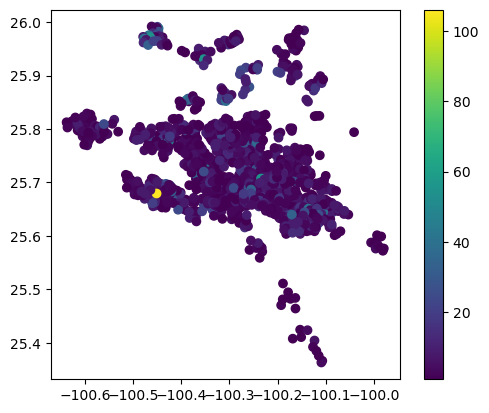

In [ ]:
# prompt: plotea con geopandas sublista_filtrada

import matplotlib.pyplot as plt

# Plotea el GeoDataFrame con la columna 'suma' como valores de color
sublista_filtrada.plot(column='suma', legend=True)
plt.show()


In [ ]:
# prompt: cargar archivo estaciones.json

import json

with open('estaciones.json', 'r') as f:
  estaciones = json.load(f)



In [ ]:
# prompt: hacer un dataframe con las "coordinates" y "id" de cada valor de estaciones

import pandas as pd

# Crear una lista para almacenar los datos de las estaciones
estaciones_data = []

# Iterar sobre los datos de las estaciones
for estacion in estaciones["features"]:
  estaciones_data.append({
      'id': estacion['id'],
      'geometry': estacion['geometry'],
      "coordenadas": estacion['geometry']['coordinates']
  })

# Crear un DataFrame a partir de la lista de datos
df_estaciones = pd.DataFrame(estaciones_data)



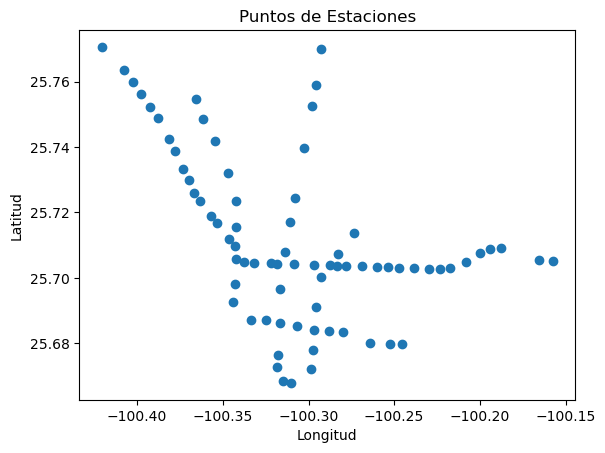

In [ ]:
# prompt: plot los puntos de df_estaciones

import matplotlib.pyplot as plt

# Extraer las coordenadas x e y del DataFrame
x_coords = [coord[0] for coord in df_estaciones['coordenadas']]
y_coords = [coord[1] for coord in df_estaciones['coordenadas']]

# Crear el gráfico de dispersión
plt.scatter(x_coords, y_coords)

# Agregar etiquetas a los ejes
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Agregar un título al gráfico
plt.title('Puntos de Estaciones')

# Mostrar el gráfico
plt.show()


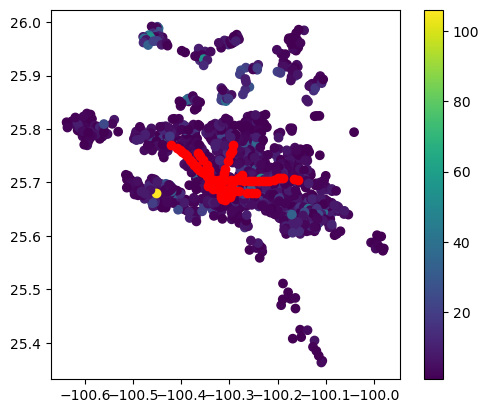

In [ ]:
# prompt: agrega los dos puntos generados al plot anterior

import matplotlib.pyplot as plt

# Plotea el GeoDataFrame con la columna 'suma' como valores de color
ax = sublista_filtrada.plot(column='suma', legend=True)

# Agrega los dos puntos generados al plot
ax.scatter(x_coords, y_coords, color='red')

plt.show()


In [ ]:
# prompt: del dataset sublista separa la variable coord_centroide y haz dos columnas nuevas que sea coordenada x y coordenada y

import pandas as pd
# Crear dos nuevas columnas 'coord_x' y 'coord_y'
sublista_filtrada[['coord_x']] = sublista_filtrada['geometry'].x.apply(pd.Series)
sublista_filtrada[['coord_y']] = sublista_filtrada['geometry'].y.apply(pd.Series)
# Eliminar la columna 'coord_centroide' si ya no es necesaria
#sublista_filtrada = sublista_filtrada.drop('coord_centroide', axis=1)




C:\Users\Samantha\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Samantha\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:

valores_a_eliminar = ['A/B', 'C+','N/D']
sublista_filtrada_socio = sublista_filtrada[~sublista_filtrada['NIVEL'].isin(valores_a_eliminar)]


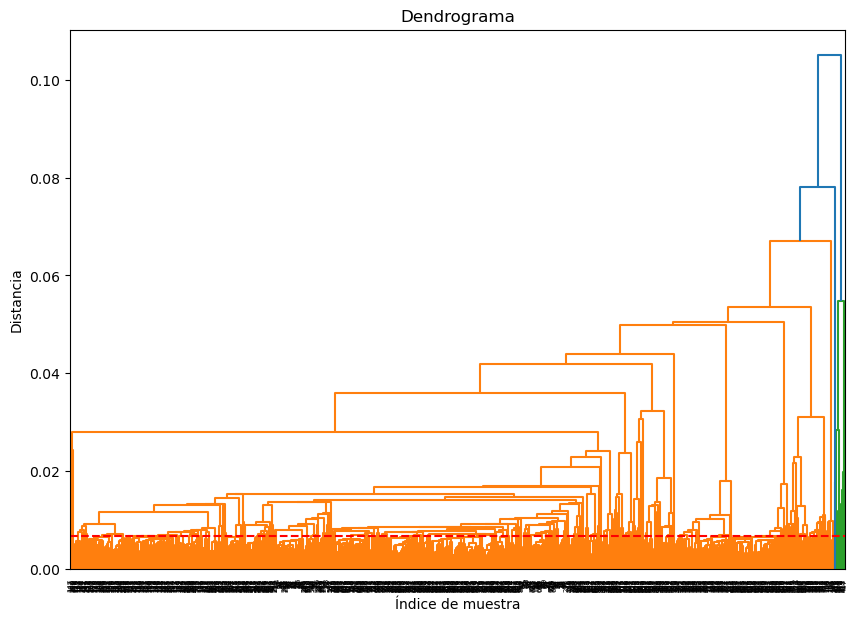

In [ ]:
# prompt: haz un kmeans de dos dimensiones con el dataset sublista_filtrada

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np
# Selecciona las columnas de coordenadas para el clustering
X = sublista_filtrada_socio[['coord_x','coord_y']]

# Calcular el enlace
linked = linkage(X, 'single')

# Crear el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', labels=np.arange(1, len(X)+1), distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrograma')
plt.xlabel('Índice de muestra')
plt.ylabel('Distancia')
plt.axhline(y=0.0067, color='r', linestyle='--')  # Línea de corte en la distancia 0.5
plt.show()


distancia_corte = 0.0067
#distancia_corte = 0.06
clusters = fcluster(linked, distancia_corte, criterion='distance')




In [ ]:
import math
def distancia_euclidiana(punto1, punto2):
    x1, y1 = punto1
    x2, y2 = punto2
    distancia = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distancia

# Ejemplo de uso
punto1 =( 25.704397132652524, -100.35186498557715)  # Primer punto
punto2 = (25.70968926872715, -100.34773330278394) # Segundo punto

distancia = distancia_euclidiana(punto1, punto2)
print(f"La distancia entre los puntos es: {distancia}")

La distancia entre los puntos es: 0.0067139784730148935


In [ ]:
def haversine(coord1, coord2):
    # Radio de la Tierra en kilómetros
    R = 6371.0

    lat1, lon1 = coord1
    lat2, lon2 = coord2

    # Convertir grados a radianes
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Diferencias
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Fórmula del Haversine
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))

    # Distancia en kilómetros
    distance = R * c
    return distance

# Calcular la distancia
distancia = haversine(punto1, punto2)
print(f"La distancia entre las coordenadas es: {distancia:.2f} km")

La distancia entre las coordenadas es: 0.72 km


In [ ]:
sublista_filtrada_socio['clasificación'] = clusters




C:\Users\Samantha\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:

numero_clusters = len(np.unique(clusters))

sublista_agrupado = sublista_filtrada_socio.groupby('clasificación').agg(
    demanda=('suma', 'sum'),               # Sumar los valores de 'suma' y ponerlos en 'demanda'
    coordenada_x=('coord_x', 'mean'),  # Promediar los valores de 'coordenada_x'
    coordenada_y=('coord_y', 'mean')
).reset_index()


Text(0.5, 1.0, 'Gráfico de puntos con coordenadas y demanda')

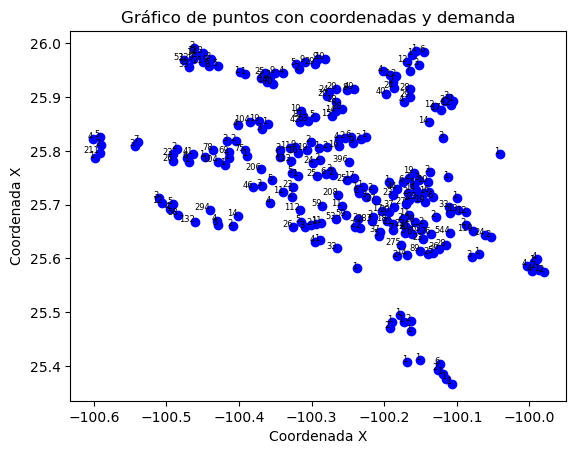

In [ ]:
#plt.figure(figsize=(8, 6))
plt.scatter(sublista_agrupado['coordenada_x'], sublista_agrupado['coordenada_y'], color='blue')

# Agregar etiquetas con el valor de demanda en cada punto
for i in range(len(sublista_agrupado)):
    plt.text(sublista_agrupado['coordenada_x'][i], sublista_agrupado['coordenada_y'][i],
             f"{sublista_agrupado['demanda'][i]:.0f}", fontsize=6, ha='right')

# Configurar los ejes
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada X')
plt.title('Gráfico de puntos con coordenadas y demanda')

In [ ]:
x_coords = [coord[0] for coord in df_estaciones['coordenadas']]
y_coords = [coord[1] for coord in df_estaciones['coordenadas']]

df_estaciones["coordenadas_x"] = x_coords
df_estaciones["coordenadas_y"] = y_coords


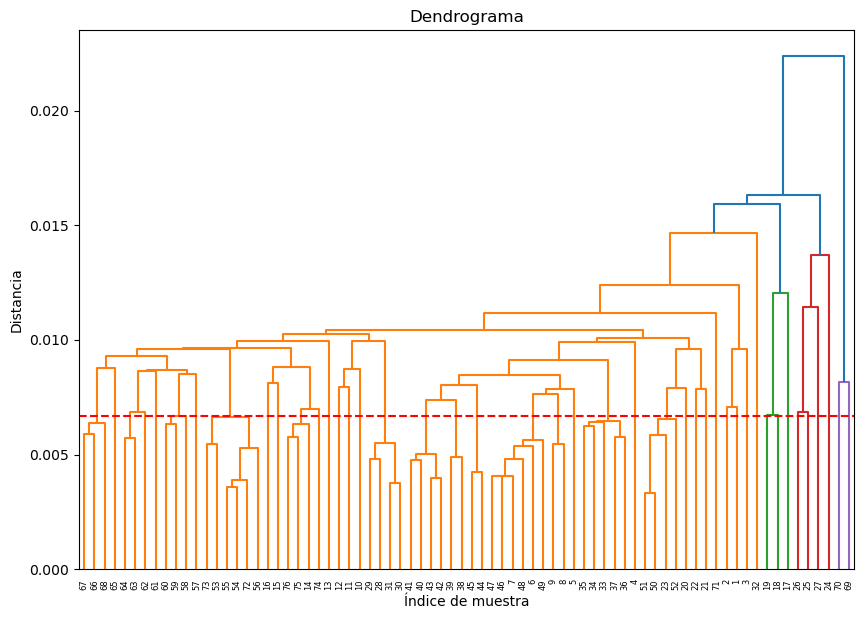

In [ ]:

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Selecciona las columnas de coordenadas para el clustering
X = df_estaciones[['coordenadas_x','coordenadas_y']]

# Calcular el enlace
linked = linkage(X, 'single')

# Crear el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', labels=np.arange(1, len(X)+1), distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrograma')
plt.xlabel('Índice de muestra')
plt.ylabel('Distancia')
plt.axhline(y=0.0067, color='r', linestyle='--')  # Línea de corte en la distancia 0.5
plt.show()


distancia_corte = 0.0067
#distancia_corte = 0.06
clusters = fcluster(linked, distancia_corte, criterion='distance')



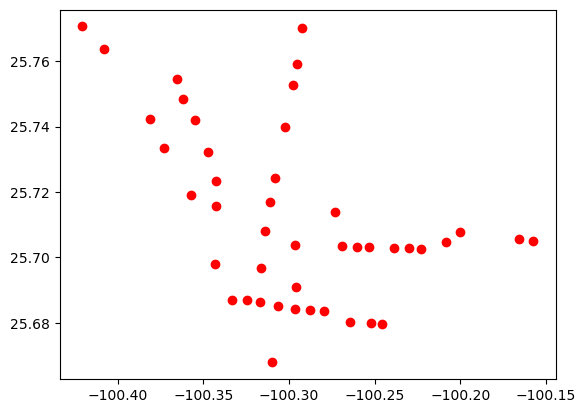

In [ ]:
df_estaciones['clasificación'] = clusters

estaciones_agrupado = df_estaciones.groupby('clasificación').agg(
    coordenada_x=('coordenadas_x', 'first'),  # Promediar los valores de 'coordenada_x'
    coordenada_y=('coordenadas_y', 'first')
).reset_index()

plt.scatter(estaciones_agrupado['coordenada_x'], estaciones_agrupado['coordenada_y'], color='red')

In [ ]:
estaciones_agrupado["clasificación"] = 1
sublista_agrupado["clasificación"]=2
estaciones_agrupado["demanda"] = 10


In [ ]:
#Checar esto las demandas de las estaciones

In [ ]:
# prompt: agrega los dos puntos generados a sublista_filtrada en los primeros dos valores

import pandas as pd
# Create a GeoDataFrame for the new points
from shapely.geometry import Point

# Concatenate the new points to the beginning of sublista_filtrada
sublista_filtrada_con_puntos = pd.concat([estaciones_agrupado, sublista_agrupado], ignore_index=True)




In [ ]:
df_matriz_traslados = pd.read_csv('matriz_traslados.csv', index_col=0)



In [ ]:
# prompt: haz una lista que sea la columna de suma de sublista_filtrada_con_puntos

demanda = sublista_filtrada_con_puntos['demanda'].tolist()


In [ ]:
cantidad_estaciones = len(estaciones_agrupado["demanda"])
cantidad_paradas = len(sublista_agrupado["demanda"])
cantidad_nodos = len(sublista_filtrada_con_puntos["demanda"])
cantidad_autobuses = 30

metro = list(range(cantidad_estaciones))  # Subway stations
paradas = list(range(cantidad_estaciones, cantidad_nodos)) # Bus stops
autobuses = list(range(cantidad_autobuses)) # Feeder routes
nodos = metro + paradas # Nodes (bus stops + subway stations)

num_metro = len(metro)
num_paradas = len(paradas)
num_autobuses = len(autobuses)
num_nodos = len(nodos)

In [ ]:
times = df_matriz_traslados /60
import numpy as np
times = np.array(times)

In [ ]:
num_iteration=200

In [ ]:
tiempo_duración = 540/3

In [ ]:
Q=300

-----Results -----------------------------
One chromosome= [[1, 217, 139], [212, 19, 276, 210, 87, 183, 161], [258, 3, 163, 54, 283, 67], [32, 121, 162, 109, 28, 149], [89, 289, 124, 206, 241, 182], [256, 187, 216, 143, 91, 129, 121, 246, 163], [77, 150, 216, 175, 16], [129, 246, 214, 8, 265, 23, 164, 122], [226, 98, 195, 226, 209, 97], [42, 265, 242, 248, 5, 76, 271], [28, 217], [57, 153, 234, 262, 246, 125, 263, 262, 282, 240], [21, 152, 274, 217], [3, 258, 73, 110, 151], [13, 255, 210, 95, 41], [103, 33, 149, 43, 206, 270, 233], [216, 190, 151, 171, 118, 272, 128], [99, 74, 194, 223, 263, 241, 52, 221, 276, 274], [113, 78, 114, 91, 72, 25, 64], [144, 29, 289, 103, 245], [255, 265, 30, 18, 59, 22], [236, 87, 87, 237, 247, 180, 272, 264, 73], [263, 151, 231, 215, 169, 140, 203, 96, 240], [2, 153, 280, 47, 127], [94, 103, 162, 173, 212, 267, 111], [38], [164, 33, 268, 239, 117, 47, 119, 273, 185], [7, 155, 169, 39, 222, 117], [89, 234, 226, 166, 247, 48, 152, 69, 178], [102, 34, 10, 32

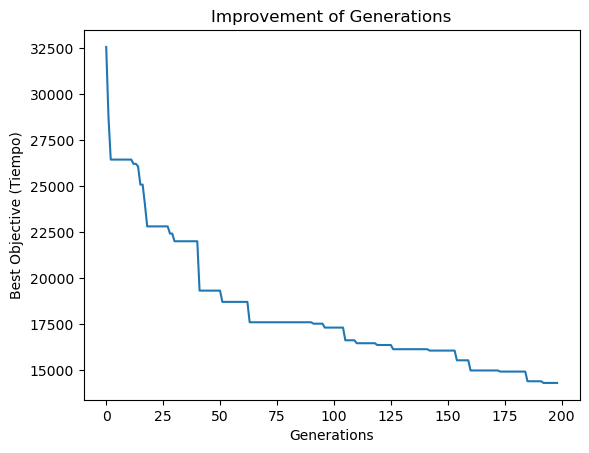

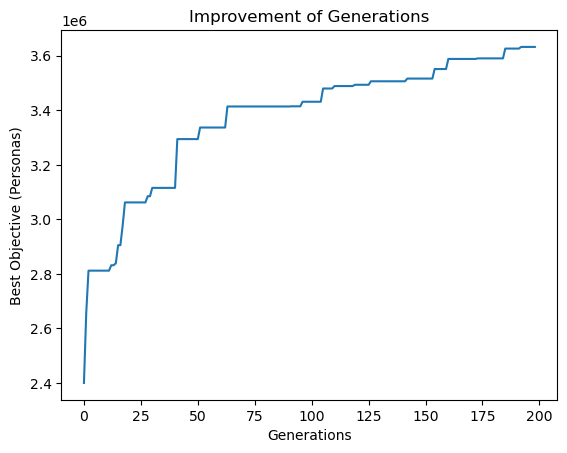

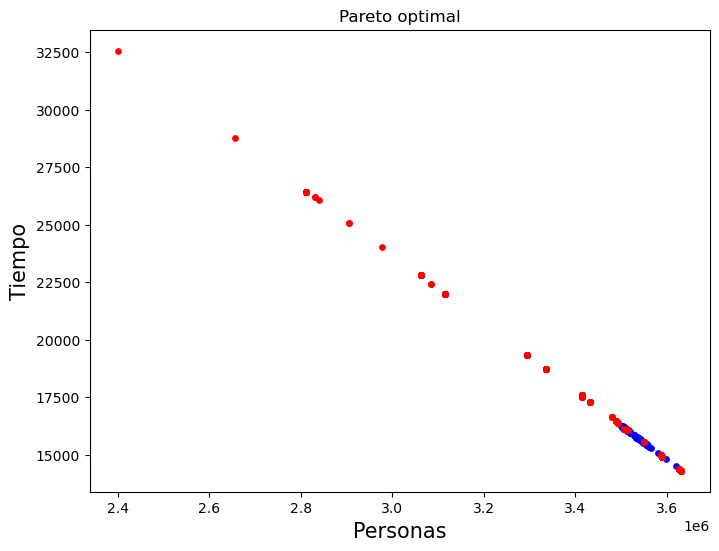

In [ ]:
best_list=[]
best_obj=[]
best_list,best_obj = todo(inicio_poblacion_9_2)

C:\Users\Samantha\AppData\Local\Temp\ipykernel_8076\3098488368.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap('tab10')(i / len(best_list[0]))  # Get a different color for each route


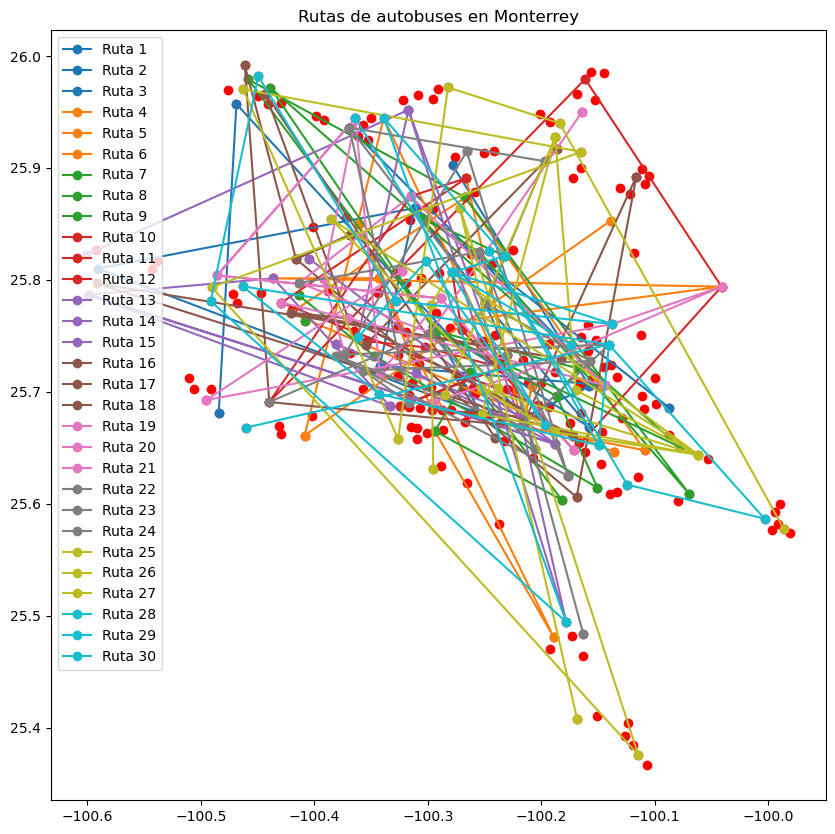

In [ ]:
# prompt: plot las rutas que estan en best_list[0] usando los puntos que estan en la sublista_filtrada_con_puntos

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

# Plotea el GeoDataFrame con la columna 'suma' como valores de color
plt.scatter(sublista_filtrada_con_puntos['coordenada_x'], sublista_filtrada_con_puntos['coordenada_y'], color='red')

# Agrega las rutas al plot
for i, ruta in enumerate(best_list[0]):
  color = plt.cm.get_cmap('tab10')(i / len(best_list[0]))  # Get a different color for each route
  x_coords = [sublista_filtrada_con_puntos.loc[nodo, 'coordenada_x'] for nodo in ruta]
  y_coords = [sublista_filtrada_con_puntos.loc[nodo, 'coordenada_y']  for nodo in ruta]
  plt.plot(x_coords, y_coords, marker='o', color=color, label=f'Ruta {i+1}')

plt.title('Rutas de autobuses en Monterrey')
plt.legend()
plt.show()


-----Results -----------------------------
One chromosome= [[247, 123, 59, 197, 277, 115, 243, 53], [49, 109, 177, 247, 222, 17, 31, 46], [18, 201, 175, 170, 160, 197], [29, 36, 92, 255, 158, 249], [99, 81, 229, 168, 256, 69, 185, 287], [228, 268, 235, 158, 177, 25, 263, 197], [23, 101, 193, 104], [151, 24, 166, 244, 101, 73, 13], [278, 175, 100, 216, 70, 205, 142, 114, 134, 61], [196, 67, 239, 203, 59], [113, 130, 154, 252, 198, 65], [242, 188, 131, 250, 122, 21, 147, 260, 103, 77], [178, 181, 283, 67, 97, 204], [197, 200, 131, 240, 279, 282], [191, 243, 15, 79], [3, 7, 60, 99, 281, 40, 8, 97, 241, 86], [31, 160, 273, 97, 122, 61, 181, 182], [13, 289, 76, 66, 255, 185], [262, 90, 156, 24, 45, 178], [264, 164, 179, 92, 245], [91, 265, 14, 100, 255, 262, 65, 222, 187, 157], [13, 61, 212, 196], [152, 197, 84, 243, 211, 184, 261, 162, 141, 274], [270, 29, 34, 146, 22], [229, 161, 71, 86, 177, 170], [157, 63, 192, 269, 205], [109, 257, 28, 289, 184, 135, 214, 150, 120, 285], [289, 137, 88,

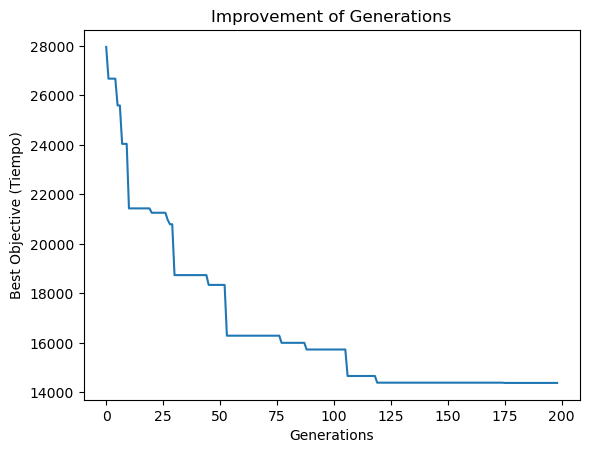

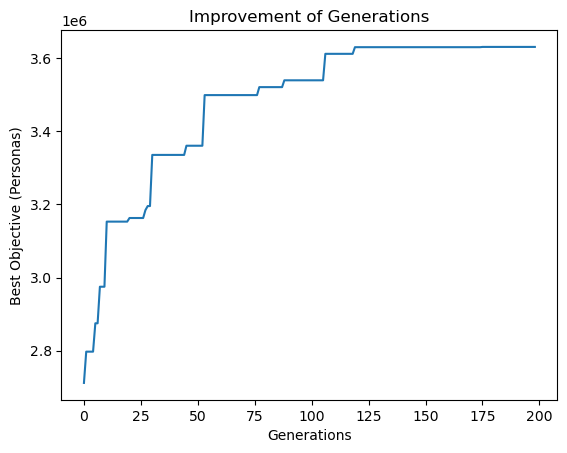

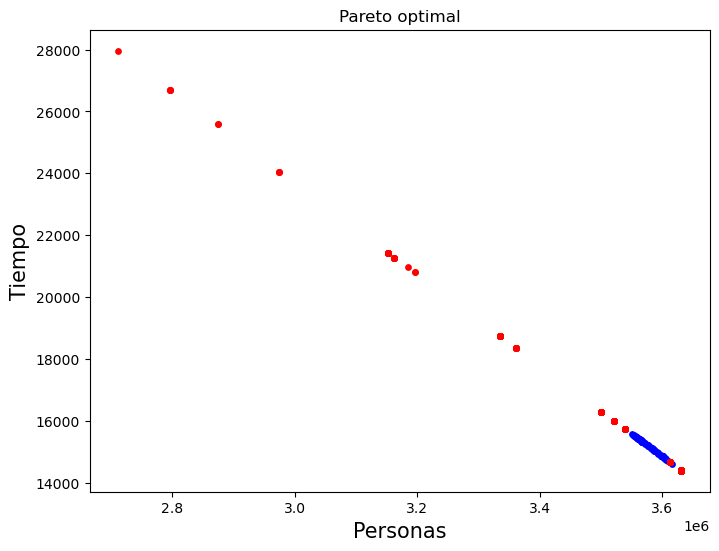

In [ ]:
best_list=[]
best_obj=[]
best_list,best_obj = todo(inicio_poblacion_9)

C:\Users\Samantha\AppData\Local\Temp\ipykernel_8076\2808256427.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap('tab10')(i / len(best_list[0]))  # Get a different color for each route


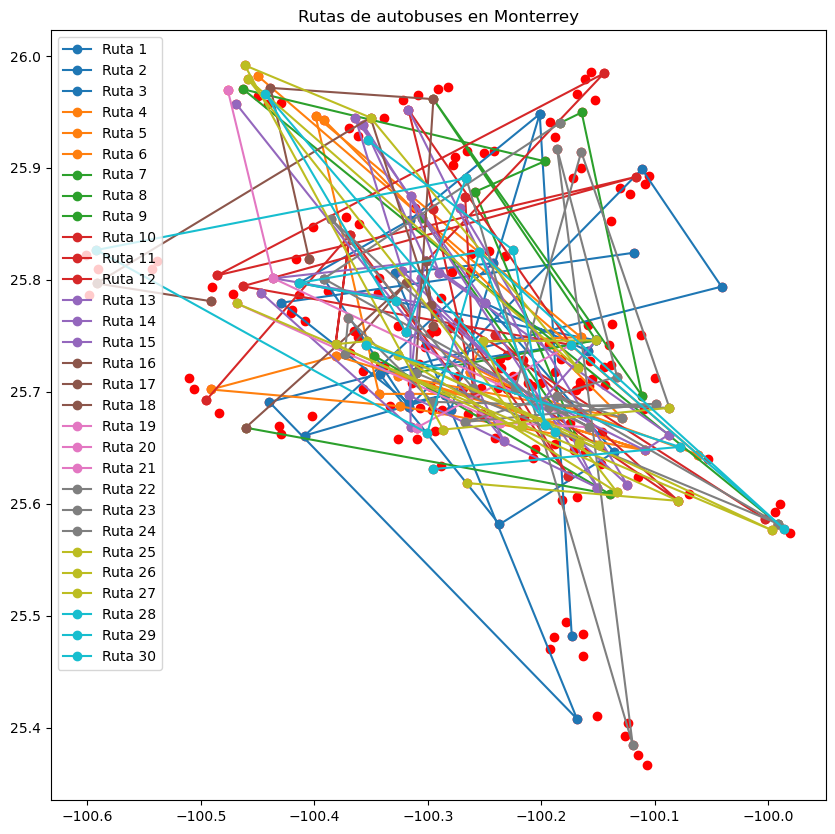

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

# Plotea el GeoDataFrame con la columna 'suma' como valores de color
plt.scatter(sublista_filtrada_con_puntos['coordenada_x'], sublista_filtrada_con_puntos['coordenada_y'], color='red')

# Agrega las rutas al plot
for i, ruta in enumerate(best_list[0]):
  color = plt.cm.get_cmap('tab10')(i / len(best_list[0]))  # Get a different color for each route
  x_coords = [sublista_filtrada_con_puntos.loc[nodo, 'coordenada_x'] for nodo in ruta]
  y_coords = [sublista_filtrada_con_puntos.loc[nodo, 'coordenada_y']  for nodo in ruta]
  plt.plot(x_coords, y_coords, marker='o', color=color, label=f'Ruta {i+1}')

plt.title('Rutas de autobuses en Monterrey')
plt.legend()
plt.show()


In [ ]:
# prompt: times to matrix

import numpy as np
times = np.array(times)


heuristico_dt= np.zeros_like(times)

for i in range(times.shape[0]):
  for j in range(times.shape[1]):
    if times[i][j] != 0:
      heuristico_dt[i][j] = demanda[j]/times[i][j]

-----Results -----------------------------
One chromosome= [[93, 94, 22, 18, 19, 23, 11, 10, 9, 11, 10, 9, 11, 10, 9, 37, 36, 38, 39, 40, 39, 40, 39, 40, 39, 7, 6, 8, 0, 1, 0, 39, 40, 39, 40, 39, 40, 39, 37, 36, 38, 37, 36, 38, 7, 6, 8, 7, 6, 8, 28, 41, 26, 15, 25, 27, 17, 18, 20, 23, 18, 19, 23, 9, 11, 10, 24, 31, 30, 26, 25, 27, 17, 13, 12, 5, 2, 3, 4, 2, 3, 4, 18, 20, 19, 23, 18, 19, 5, 12, 5, 2, 4, 3, 35, 32, 7], [56, 24, 31, 29, 42, 35, 29, 42, 34, 37, 36, 38, 33, 34, 33, 34, 37, 36, 0, 1, 0, 1, 0, 1, 0, 1, 39, 40, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 7, 6, 8, 7, 6, 8, 28, 41, 26, 25, 27, 17, 29, 28, 41, 26, 32, 14, 13, 5, 2, 3, 4, 13, 12, 20, 5, 2, 3, 5, 2, 3, 4, 5, 2, 3, 13, 12, 5, 4, 3, 4, 5, 2, 3, 14, 13, 12, 13, 12, 13, 5, 2, 3, 19, 23, 11, 9, 10, 9, 10, 11, 10, 9, 11, 10, 9, 11, 23], [149, 146, 10, 9, 21, 22, 24, 31, 30, 28, 41, 26, 15, 25, 27, 17, 25, 27, 17, 32, 14, 13, 12, 15, 14, 29, 42, 33, 34, 37, 36, 38, 33, 35, 28, 41, 26, 15, 25, 27, 17, 25, 27, 17, 25, 27, 17, 24, 31, 30,

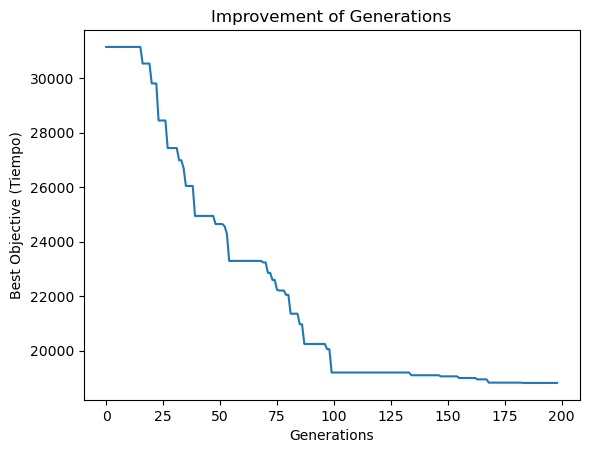

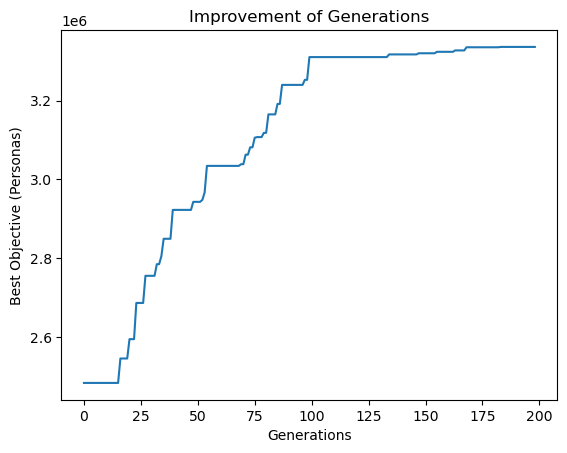

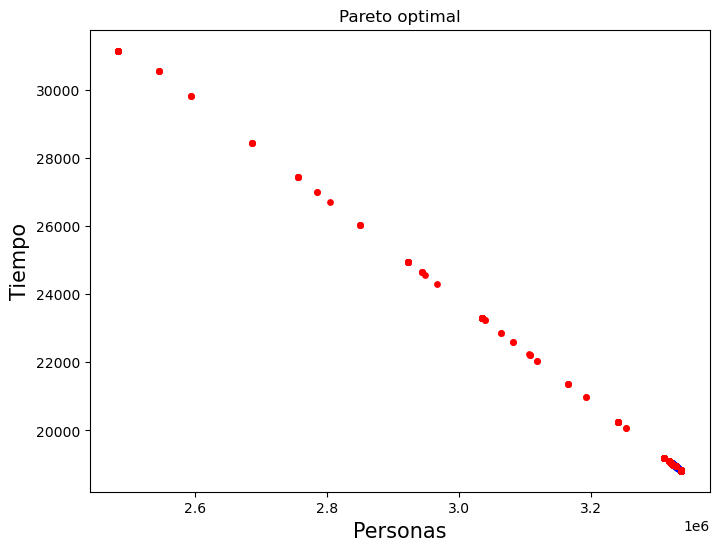

In [ ]:
best_list=[]
best_obj=[]
best_list,best_obj = todo2()

C:\Users\Samantha\AppData\Local\Temp\ipykernel_8076\2808256427.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap('tab10')(i / len(best_list[0]))  # Get a different color for each route


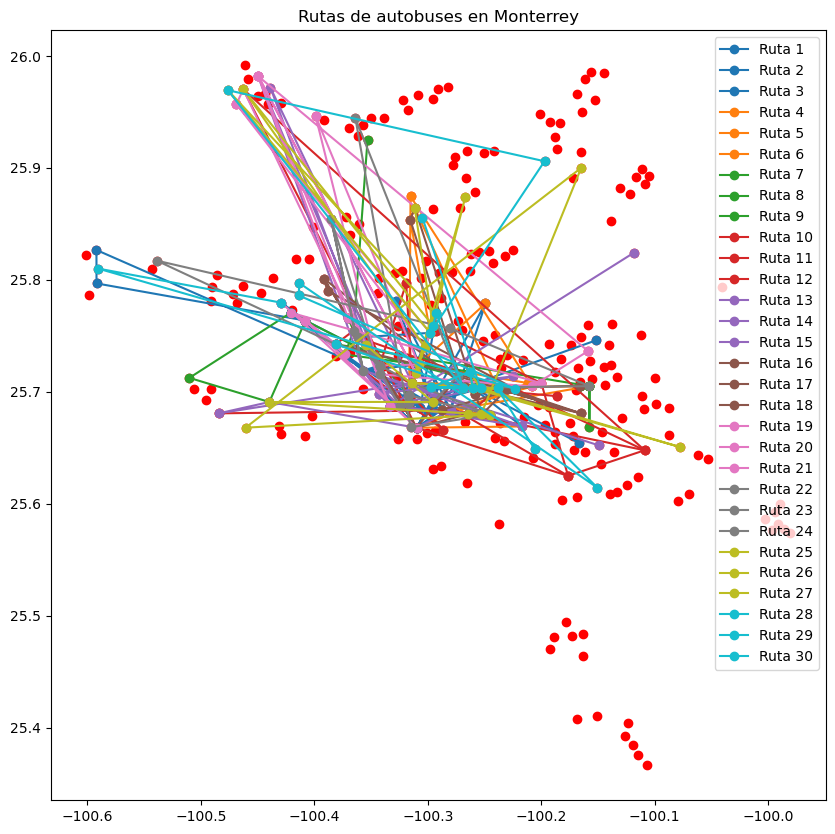

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

# Plotea el GeoDataFrame con la columna 'suma' como valores de color
plt.scatter(sublista_filtrada_con_puntos['coordenada_x'], sublista_filtrada_con_puntos['coordenada_y'], color='red')

# Agrega las rutas al plot
for i, ruta in enumerate(best_list[0]):
  color = plt.cm.get_cmap('tab10')(i / len(best_list[0]))  # Get a different color for each route
  x_coords = [sublista_filtrada_con_puntos.loc[nodo, 'coordenada_x'] for nodo in ruta]
  y_coords = [sublista_filtrada_con_puntos.loc[nodo, 'coordenada_y']  for nodo in ruta]
  plt.plot(x_coords, y_coords, marker='o', color=color, label=f'Ruta {i+1}')

plt.title('Rutas de autobuses en Monterrey')
plt.legend()
plt.show()
